### Load modules

In [1]:
import pandas as pd
import numpy as np 
import psycopg2
import json
from pathlib import Path
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from queries import ICD_QUERY, ADMISSIONS_QUERY
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.pipeline import Pipeline

In [2]:
ICD_CM_9_TO_10_MAPPING_FILE = "/gpfs/data/bbj-lab/users/eddie/ethos-paper/ethos/data/icd_cm_9_to_10_mapping.csv.gz"
ICD_CM_10_TO_9_MAPPING_FILE = "icd_cm_10_to_9_mapping.csv"

### Load Functions

In [3]:
def connect_to_database(cdict:dict):
    """Connect to database
    @var cdict (str[str]) : credentials 
    
    @return cn : connection to schema 
    @return cur : cursor of the connection 
    """
    # Connect to local postgres version of mimic
    schema_name=cdict["schema_name"]
    # dbname=cdict["dbname"]
    try:
        cn = psycopg2.connect(
            host=cdict["host"],
            port=cdict["port"],
            user=cdict["user"],
            password=cdict["password"],
            dbname=cdict["dbname"],  # Replace with your actual database name
            options="-c client_encoding=UTF8"
        )
        print("Connected to the PostgreSQL server successfully!")

        print('Connected to postgres {}.{}.{}!'.format(int(cn.server_version/10000),
                                                    (cn.server_version - int(cn.server_version/10000)*10000)/100,
                                                    (cn.server_version - int(cn.server_version/100)*100)))
        cur = cur = cn.cursor()
        set_schema_path = f"SET search_path to {schema_name}; COMMIT;"
        cur.execute(set_schema_path)
        return cn, cur 
    
    except psycopg2.Error as error:
        print(error)
        return None, None

In [4]:
def create_icd_translation(is_9_to_10:bool=True):
    """Return a dict that maps icd codes from one of versions to the other one (9 to 10 or 10 to 9)
    @return version_mapping (str[str])
    """
    if is_9_to_10:
        version_mapping = pd.read_csv(ICD_CM_9_TO_10_MAPPING_FILE, dtype=str)
        version_mapping.drop_duplicates(subset="icd_9", inplace=True)
        version_mapping = version_mapping.groupby("icd_9").icd_10.apply(
            lambda values: min(values, key=len)
        )
    else:
        version_mapping = pd.read_csv(ICD_CM_10_TO_9_MAPPING_FILE, dtype=str)
        version_mapping.drop_duplicates(subset="icd10cm", inplace=True)
        version_mapping = version_mapping.groupby("icd10cm").icd9cm.apply(
            lambda values: min(values, key=len)
        )        
    return version_mapping.to_dict()

In [5]:
def create_icd_9_titles():
    title_mapping = pd.read_csv('icd9dx2015.csv', dtype=str)
    title_mapping.drop_duplicates(subset='dgns_cd', inplace=True)
    title_mapping = title_mapping.groupby("dgns_cd").shortdesc.apply(
        lambda values: min(values, key=len)
    )
    return title_mapping.to_dict()

In [6]:
def translate_icd(version_mapping:dict, left_digits:int|None,
                  df:pd.DataFrame, from_version:int=9, to_version:int=10, version_col:str='icd_version', code_col:str="icd_code") -> pd.DataFrame:
    """Map df icd code columns from version 9 to version 10
    @var version_mapping (str[str]) : dict that maps between icd code 9 and 10 
    @var left_digits (int) : icd code rolled up to certain left digits 
    @var df (pd.Dataframe) 
    @var version_col (str)
    @var code_col (str)

    @return df (pd.DataFrame) 
    """
    assert from_version == 9 or from_version == 10
    assert to_version == 9 or to_version == 10

    df_new = df.copy()
    
    is_from_version = df_new[version_col] == from_version
    df_new[code_col] = df_new[code_col].astype(str).str.strip()

    # Function to map based on original and truncated lengths
    def map_code(code):
        mapped = version_mapping.get(code)  # Attempt mapping on original
        if mapped is not None:
            return mapped
        if left_digits is not None and len(code) > left_digits:
            truncated = code[:left_digits]
            return version_mapping.get(truncated, code)  # Map truncated or keep original
        return code  # Keep original if no mapping found

    df_new.loc[is_from_version, code_col] = df_new.loc[is_from_version, code_col].apply(map_code)
    
    # Update icd_version to 10 for successfully mapped codes
    mask = is_from_version & df_new[code_col].isin(version_mapping.values())
    df_new.loc[mask, version_col] = to_version

    # roll up icd codes
    if left_digits is not None:
        df_new[code_col] = df_new[code_col].apply(lambda x: x[:left_digits] if len(x) > left_digits else x)

    return df_new

In [7]:
def load_query_data(path:str, query:str, cn):
    """Query data or load data if data are pre-saved. 
    @var path (str) 
    @var query (str)
    @var cn : connection to schema 

    @return df (pd.DataFrame)
    """
    path = Path(path).resolve()
    
    # if data pre-saved -> load 
    # else if connection to database is successful -> query data 
    # else : error
    if path.exists():
        df = pd.read_csv(path)
        return df
    elif cn is not None:
        df = pd.read_sql(query, cn)
        df.to_csv(path, compression="gzip", index=False)
        return df
    else:
        raise ValueError(f"{path} does not exist and fail to connect to PostgreSQL.")

In [8]:
def get_icd_code_dummies(data_path:str, col_path:str, df:pd.DataFrame, key_col="hadm_id", code_col="icd_code") -> pd.DataFrame:
    """Get dummies of icd codes for each key columns or load dummies if data are pre-saved. 
    @var data_path (str)
    @var col_path (str)
    @var df (pd.Dataframe) : df contains icd codes 
    @var key_col (str) : key column for groupby 
    @var code_col (str) 

    @return icd_dummies (pd.DataFrame) : key_col, icd_cols 
    """
    data_path = Path(data_path).resolve()
    col_path = Path(col_path).resolve()
    if data_path.exists():
        sM = sparse.load_npz(data_path)
        col_names_loaded = np.load(col_path, allow_pickle=True)
        icd_dummies = pd.DataFrame(data=sM.toarray(), columns=col_names_loaded)
    else: 
        icd_dummies = pd.get_dummies(df.set_index(key_col)[code_col]).groupby(key_col).max().reset_index()
        sM = sparse.csr_matrix(icd_dummies.values)
        sparse.save_npz(data_path, sM)
        column_names = icd_dummies.columns.tolist()
        np.save(col_path, column_names)

    return icd_dummies

In [9]:
def train_test_split(df:pd.DataFrame, time_col:str="admittime", key_col:str="subject_id", size:tuple=(0.7, 0.1, 0.2)):
    """Sort by time column and then split the dataset into train, validation, test datasets. 
    @var df (pd.DataFrame)
    @var time_col (str)
    @var key_col (str)
    @var size (tuple[float])

    @return 
    """
    assert len(size) == 3
    assert sum(size) == 1
    n = len(df)
    train_size = int(size[0]*n)
    valid_size = int(size[1]*n)

    # sort by time
    # Let's say size = (0.7, 0.1, 0.2) for train, validation, test datasets 
    # pick first 70% admissions as train 
    # rest being validation and test
    # if subjects in validation and test are in train dataset, filter out
    df = df.sort_values(by=time_col).reset_index(drop=True)
    train_dataset = df.iloc[:train_size, :]
    valid_dataset = df.iloc[train_size:(train_size+valid_size), :]
    test_dataset = df.iloc[(train_size+valid_size):, :]

    # remove patients in valid/test who are in training 
    subject_ids = train_dataset[key_col]

    mask = valid_dataset[key_col].isin(subject_ids)
    valid_dataset = valid_dataset[~mask]

    mask = test_dataset[key_col].isin(subject_ids)
    test_dataset = test_dataset[~mask]

    # shuffle
    train_dataset = train_dataset.sample(frac = 1)
    valid_dataset = valid_dataset.sample(frac = 1)
    test_dataset = test_dataset.sample(frac = 1)

    return train_dataset, valid_dataset, test_dataset

In [10]:
def sklearn_train_loop(model, 
                       train_X:pd.DataFrame, train_y:pd.DataFrame, 
                       test_X:pd.DataFrame, test_y:pd.DataFrame):
    print("-"*50)
    print(model)
    model.fit(train_X, train_y)

    for mode in ("train", "test"):
        print("*"*30)
        if mode == "train":
            X, y = train_X, train_y 
        else:
            X, y = test_X, test_y 
        
        preds = model.predict(X)

        # confusion matrix
        cm = confusion_matrix(y, preds, labels=model.classes_)
        print(f"{mode} confusion matrix:", cm)

        # recall score 
        print(f"{mode} recall:", recall_score(y, preds))

        # balanced accuracy
        balanced_accuracy = balanced_accuracy_score(y, preds)
        print("{} balanced accuracy: {:.2f}%".format(mode, balanced_accuracy*100))

        # RoC 
        # print(f"{mode} RoC AUC score:", roc_auc_score(y, preds))
        print(f"{mode} RoC AUC score:", roc_auc_score(y, model.predict_proba(X)[:, 1]))

    return model 

### Get data

In [11]:
creds_path = Path("creds.json").resolve()
with open(creds_path, "r") as f:
    cdict = json.load(f)
cn, cur = connect_to_database(cdict=cdict)
icd_code_digits = 5

Connected to the PostgreSQL server successfully!
Connected to postgres 16.0.02.2!


In [12]:
icd_df = load_query_data('data/icd.csv.gz', ICD_QUERY, cn)
admissions_df = load_query_data('data/admissions.csv.gz', ADMISSIONS_QUERY, cn)

# get dummies
admissions_df = pd.get_dummies(admissions_df, columns=['gender'], drop_first=True)

# map version 10 to version 9
version_mapping = create_icd_translation(is_9_to_10=False)

icd_df = translate_icd(version_mapping=version_mapping, from_version=10, to_version=9, left_digits=icd_code_digits, df=icd_df)

icd_dummies = get_icd_code_dummies(
    data_path=f"data/icd_dummies_d{icd_code_digits}.npz", 
    col_path=f"data/icd_dummies_col_names_d{icd_code_digits}.npy", 
    df=icd_df
)
print(f"icd dataframe: shape is {icd_df.shape}. Dataframe peek:\n{icd_df.head(10)}")
print(f"icd_dummies dataframe: shape is {icd_dummies.shape}. Dataframe peek:\n{icd_dummies.head(10)}")
print(f"admissions dataframe: shape is {admissions_df.shape}. Dataframe peek:\n{admissions_df.head(10)}")

icd dataframe: shape is (4756326, 6). Dataframe peek:
   subject_id   hadm_id  seq_num icd_code  icd_version  \
0    10000032  22595853        2    78959            9   
1    10000032  22595853        4    07070            9   
2    10000032  22595853        6    29680            9   
3    10000032  22595853        7    30981            9   
4    10000032  22841357        2    78959            9   
5    10000032  22841357        3     2875            9   
6    10000032  22841357        4     2761            9   
7    10000032  22841357        7      V08            9   
8    10000032  22841357        8     3051            9   
9    10000032  25742920        2    78959            9   

                                          long_title  
0                                      Other ascites  
1  Unspecified viral hepatitis C without hepatic ...  
2                      Bipolar disorder, unspecified  
3                      Posttraumatic stress disorder  
4                               

In [13]:
main_df = pd.merge(left=admissions_df, right=icd_dummies, on="hadm_id")
print(f"main dataframe: shape is {main_df.shape}. Dataframe peek:\n{main_df.head(10)}")

main dataframe: shape is (430852, 10289). Dataframe peek:
    hadm_id  subject_id            admittime  death  admit_age  gender_M  \
0  23052089    10000084  2160-11-21 01:56:00      0       72.0         1   
1  29888819    10000084  2160-12-28 05:11:00      0       72.0         1   
2  27897940    10000764  2132-10-14 23:31:00      0       86.0         1   
3  21334040    10001186  2190-07-19 07:15:00      0       48.0         0   
4  24016413    10001186  2188-10-20 07:15:00      0       46.0         0   
5  24906418    10001186  2188-09-24 15:33:00      0       46.0         0   
6  23005466    10001319  2135-07-20 03:45:00      0       30.0         0   
7  24591241    10001319  2138-11-09 20:00:00      0       33.0         0   
8  29230609    10001319  2134-04-15 07:59:00      0       29.0         0   
9  25563031    10001725  2110-04-11 15:08:00      0       46.0         0   

   0020  0029  0030  0031  ...  Z7984  Z8342  Z8343  Z8600  Z8615  Z871  Z891  \
0     0     0     0     

In [14]:
# split dataset 
train_dataset, valid_dataset, test_dataset = train_test_split(df=main_df)

# drop key columns and time columns
train_dataset = train_dataset.drop(columns=['hadm_id', 'subject_id', 'admittime'])
valid_dataset = valid_dataset.drop(columns=['hadm_id', 'subject_id', 'admittime']) 
test_dataset = test_dataset.drop(columns=['hadm_id', 'subject_id', 'admittime'])

# get X, y
train_X, train_y = train_dataset.iloc[:, 1:], train_dataset.iloc[:, 0].values
valid_X, valid_y = valid_dataset.iloc[:, 1:], valid_dataset.iloc[:, 0].values
test_X, test_y = test_dataset.iloc[:, 1:], test_dataset.iloc[:, 0].values

In [15]:
# normalization (mainly affect age column)
preprocessor = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('var_threshold', VarianceThreshold())
]) 
train_X = preprocessor.fit_transform(train_X)
valid_X = preprocessor.transform(valid_X)
test_X = preprocessor.transform(test_X)

In [16]:
var_threshold = preprocessor.named_steps['var_threshold']
retained_mask = var_threshold.get_support()
# Assuming `col_names` contains the original column names
retained_col_names = train_dataset.columns[1:][retained_mask]

### Modeling

In [17]:
# models 
lr = sklearn_train_loop(LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=300), 
            train_X, train_y,
            test_X, test_y)
print(lr.coef_[0])

--------------------------------------------------
LogisticRegression(class_weight='balanced', max_iter=300, n_jobs=-1)


******************************
train confusion matrix: [[284999  10401]
 [   101   6095]]
train recall: 0.9836991607488702
train balanced accuracy: 97.42%
train RoC AUC score: 0.9924875394635103
******************************
test confusion matrix: [[81485  3003]
 [  194  1300]]
test recall: 0.8701472556894244
test balanced accuracy: 91.73%
test RoC AUC score: 0.9774514369062908
[ 4.00801211e+00 -6.31586476e-02 -3.44098138e-02 ... -1.36327025e-04
 -1.63004149e-01 -1.18309590e-02]


In [18]:
# remove high correlation features
# Create correlation matrix
corr_matrix = np.absolute(np.corrcoef(train_X.T))
print(corr_matrix.shape)
print(corr_matrix)

(9812, 9812)
[[1.00000000e+00 3.64687152e-02 3.76852944e-03 ... 1.09617228e-03
  1.27040410e-04 6.62793551e-04]
 [3.64687152e-02 1.00000000e+00 8.35164105e-04 ... 1.74660262e-03
  1.89837391e-03 6.45360343e-04]
 [3.76852944e-03 8.35164105e-04 1.00000000e+00 ... 9.94724644e-06
  9.94724644e-06 2.22428667e-05]
 ...
 [1.09617228e-03 1.74660262e-03 9.94724644e-06 ... 1.00000000e+00
  3.31570484e-06 7.41419057e-06]
 [1.27040410e-04 1.89837391e-03 9.94724644e-06 ... 3.31570484e-06
  1.00000000e+00 7.41419057e-06]
 [6.62793551e-04 6.45360343e-04 2.22428667e-05 ... 7.41419057e-06
  7.41419057e-06 1.00000000e+00]]


In [19]:
tmp = pd.DataFrame(data=train_X, columns=retained_col_names)

# Get the upper triangle of the correlation matrix
upper = np.triu(corr_matrix, k=1)

# Find columns (features) with correlation greater than 0.95
to_drop = set()
for col in range(upper.shape[1]):
    if any(upper[:, col] > 0.95):
        to_drop.add(col)

# Drop features from the original DataFrame using their indices
tmp.drop(tmp.columns[list(to_drop)], axis=1, inplace=True)

# Print the updated shape of the DataFrame
print(tmp.shape)

(301596, 9764)


In [20]:
# print(np.bincount(train_y))

In [21]:
# log_reg = sm.Logit(train_y, tmp.iloc[:, :10]).fit_regularized()
# print(log_reg.summary())

In [22]:
# lr = sm.GLM(train_y, tmp, 
#                 family=sm.genmod.families.Binomial(link=sm.genmod.families.links.Logit())
#                 ).fit_regularized('elastic_net', maxiter=100, opt_method='lbfgs')
# print(lr.summary())

In [23]:
rf = sklearn_train_loop(RandomForestClassifier(max_depth=4, n_jobs=-1, class_weight='balanced'), 
            train_X, train_y,
            test_X, test_y)

# lower the depth to 3 or 4

--------------------------------------------------
RandomForestClassifier(class_weight='balanced', max_depth=4, n_jobs=-1)


******************************
train confusion matrix: [[276951  18449]
 [  1226   4970]]
train recall: 0.802130406714009
train balanced accuracy: 86.98%
train RoC AUC score: 0.9530653971505412
******************************
test confusion matrix: [[78986  5502]
 [  267  1227]]
test recall: 0.821285140562249
test balanced accuracy: 87.81%
test RoC AUC score: 0.955380235394122


In [24]:
pos_weight = (len(train_y) - sum(train_y)) / sum(train_y)
xgboost = sklearn_train_loop(XGBClassifier(n_jobs=-1, scale_pos_weight=pos_weight), 
            train_X, train_y,
            test_X, test_y)

# TODO:
# number of estimators 
# depth 
# regularization

--------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


******************************
train confusion matrix: [[284831  10569]
 [    88   6108]]
train recall: 0.9857972885732731
train balanced accuracy: 97.50%
train RoC AUC score: 0.9941706814036444
******************************
test confusion matrix: [[81417  3071]
 [  170  1324]]
test recall: 0.8862115127175368
test balanced accuracy: 92.49%
test RoC AUC score: 0.9808922430244286


### Plotting

In [25]:
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

black_color = "#404040ff"
gray_color = "#b2b2b2ff"
orange_color = "#ff8533ff"
font_size = 12

sns.set(context="paper", style="white")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelcolor'] = black_color
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = black_color
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['text.color'] = black_color
plt.rcParams['xtick.color'] = black_color
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.color'] = black_color
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size

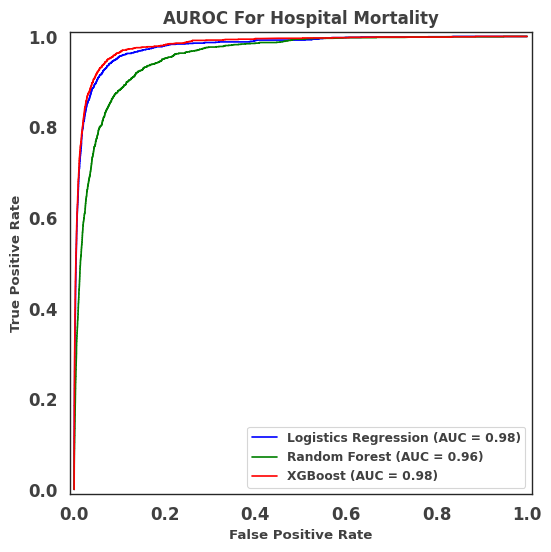

In [26]:
models = [lr, rf, xgboost]  # Replace with your actual models
model_names = ["Logistics Regression", "Random Forest", "XGBoost"]  # Replace with your model names
colors = ['blue', 'green', 'red']  # Colors for each model

plt.figure(figsize=(8, 6))

for model, name, color in zip(models, model_names, colors):
    # Get predicted probabilities for the positive class
    y_pred = model.predict_proba(test_X)[:, 1]  
    fpr, tpr, _ = roc_curve(test_y, y_pred)  
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=plt.gca(), color=color)

# Add plot title and legend
plt.title(f"AUROC For Hospital Mortality")
plt.legend(loc="lower right")
plt.savefig(f"plots/roc_d{icd_code_digits}.png")

# title: what the picture tells us instead of fact 
# or go into the captions


In [27]:
title_mapping = create_icd_9_titles()
print(retained_col_names)
titles = [title_mapping.get(x, x) for x in retained_col_names]

Index(['admit_age', 'gender_M', '0020', '0029', '0030', '0031', '00322',
       '00324', '00329', '0038',
       ...
       'Z68', 'Z7984', 'Z8342', 'Z8343', 'Z8600', 'Z8615', 'Z871', 'Z891',
       'Z900', 'Z9682'],
      dtype='object', length=9812)


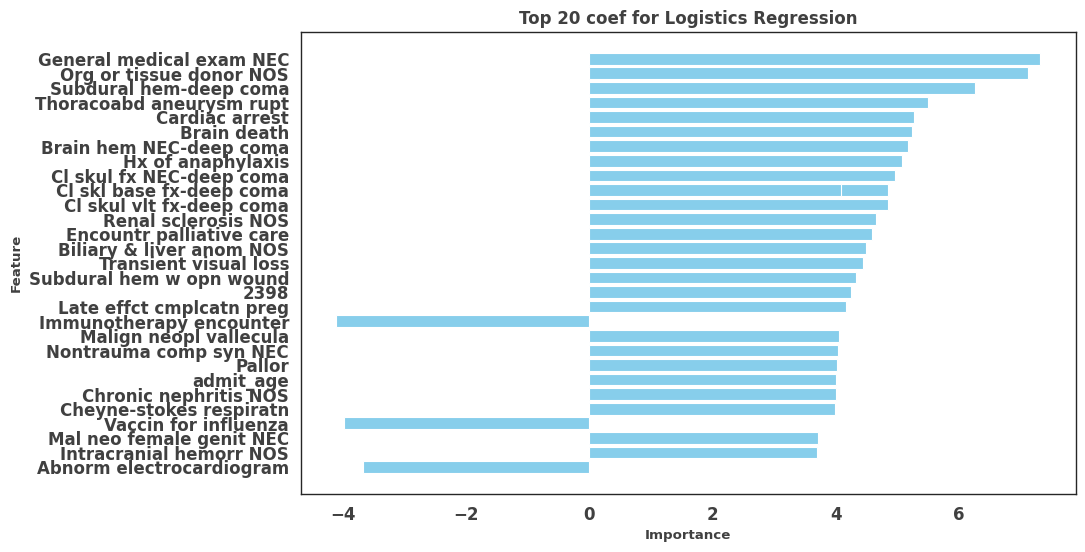

In [28]:
feature_importance = pd.DataFrame({
    'Feature': titles,  # Adjust index as per your features
    'Coefficient': lr.coef_[0]
})

# print(feature_importance.head())

# Sort by absolute value of the coefficient and keep top 20
lr_top_features = feature_importance.reindex(
    feature_importance['Coefficient'].abs().sort_values(ascending=False).index
).head(30)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(lr_top_features['Feature'], lr_top_features['Coefficient'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 coef for Logistics Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

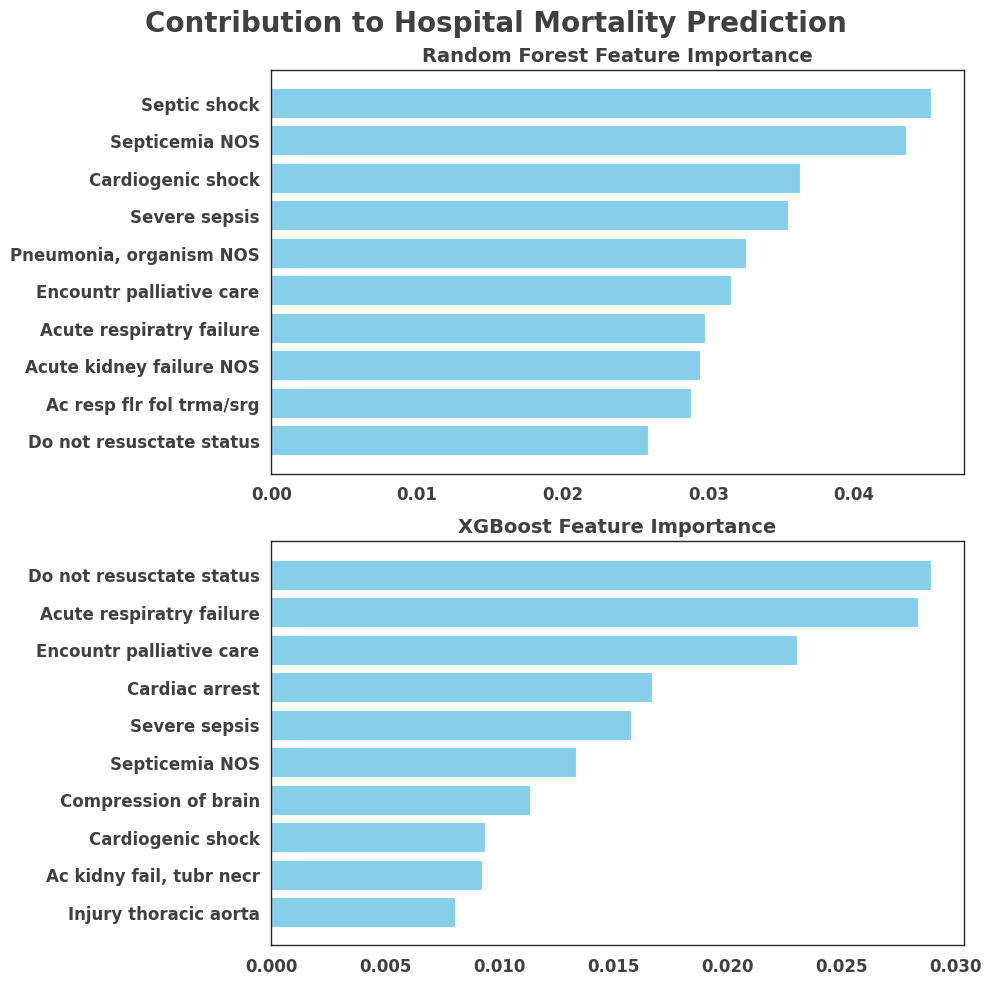

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# Model titles for the subplot
model_titles = ["Random Forest Feature Importance", "XGBoost Feature Importance"]

# Loop through both models
for i, (model, title) in enumerate(zip([rf, xgboost], model_titles)):
    ax: plt.Axes = axes[i]  # Correctly select the subplot axis
    
    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': titles,  # Replace 'titles' with the actual feature names list
        'Importance': model.feature_importances_
    })
    
    # Sort by importance and take top 20
    top_features = feature_importance.nlargest(10, 'Importance')
    
    # Plot feature importance
    ax.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    ax.invert_yaxis()  # Reverse the y-axis for a better view
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("") # ax.set_xlabel("Importance")
    # ax.set_ylabel("Features")

# Adjust spacing between subplots
fig.suptitle("Contribution to Hospital Mortality Prediction", fontsize=20, fontweight="bold")
fig.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

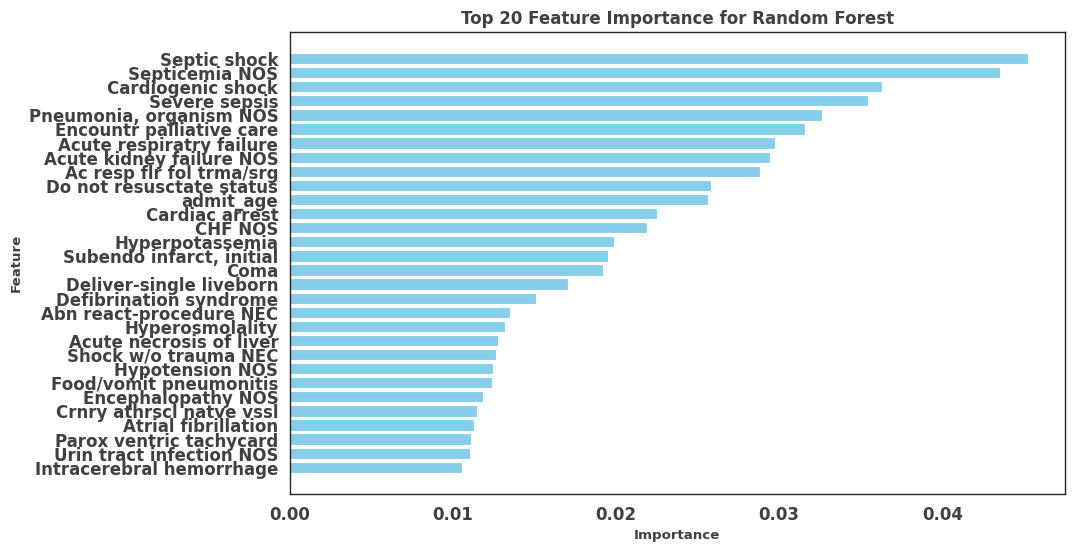

In [30]:
feature_importance = pd.DataFrame({
    'Feature': titles,  # Adjust index as per your features
    'Importance': rf.feature_importances_
})

# Sort by absolute value of the coefficient and keep top 20
rf_top_features = feature_importance.reindex(
    feature_importance['Importance'].abs().sort_values(ascending=False).index
).head(30)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(rf_top_features['Feature'], rf_top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# RF keep feature importance


# show the table with formal title and the importance and rank it
# keep the plot


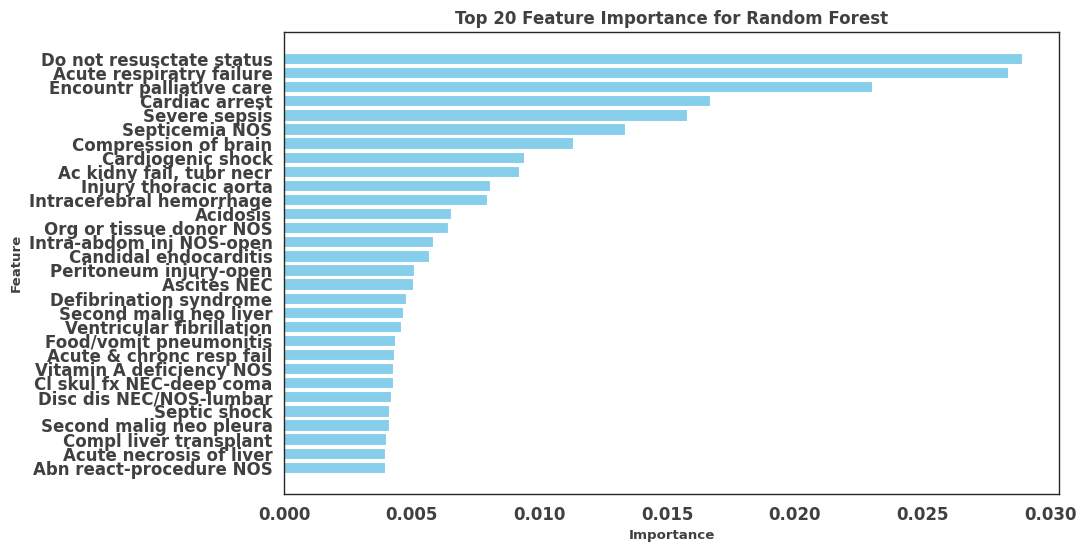

In [31]:
feature_importance = pd.DataFrame({
    'Feature': titles,  # Adjust index as per your features
    'Importance': xgboost.feature_importances_
})

# Sort by absolute value of the coefficient and keep top 20
xgboost_top_features = feature_importance.reindex(
    feature_importance['Importance'].abs().sort_values(ascending=False).index
).head(30)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(xgboost_top_features['Feature'], xgboost_top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [32]:
lr_top_features = set(lr_top_features['Feature'])
rf_top_features = set(rf_top_features['Feature'])
xgboost_top_features = set(xgboost_top_features['Feature'])


In [33]:
lr_top_features & rf_top_features & xgboost_top_features

{'Cardiac arrest', 'Encountr palliative care'}

In [34]:
lr_top_features & rf_top_features

{'Cardiac arrest', 'Encountr palliative care', 'admit_age'}

In [35]:
lr_top_features & xgboost_top_features

{'Cardiac arrest',
 'Cl skul fx NEC-deep coma',
 'Encountr palliative care',
 'Org or tissue donor NOS'}

In [36]:
rf_top_features & xgboost_top_features

{'Acute necrosis of liver',
 'Acute respiratry failure',
 'Cardiac arrest',
 'Cardiogenic shock',
 'Defibrination syndrome',
 'Do not resusctate status',
 'Encountr palliative care',
 'Food/vomit pneumonitis',
 'Intracerebral hemorrhage',
 'Septic shock',
 'Septicemia NOS',
 'Severe sepsis'}